07391449,

08436710

In [3]:
import numpy as np
import keras
import cv2
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [4]:
file_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\img"
labels_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv"

In [5]:
df = pd.read_csv(labels_path)
sample_size = 1000
df = df.drop(columns="Unnamed: 0")

temp = df["file_name"]
df.insert(loc=0, column="file_names", value=temp)
df = df.drop(columns="file_name")

df["eye_color"] = df["eye_color"].replace(to_replace=[0], value=["Brown"])
df["eye_color"] = df["eye_color"].replace(to_replace=[1], value=["Blue"])
df["eye_color"] = df["eye_color"].replace(to_replace=[2], value=["Green"])
df["eye_color"] = df["eye_color"].replace(to_replace=[3], value=["Hazel"])
df["eye_color"] = df["eye_color"].replace(to_replace=[4], value=["Black"])

one_hot = pd.get_dummies(df["eye_color"])
df = df.join(one_hot)

df = df.drop(df.index[sample_size:])

In [6]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [7]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [8]:
img_path = os.path.join(file_path, df["file_names"].iloc[3])
img = cv2.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        roi_color_eye = roi_color[ey:ey+eh, ex:ex+ew]
        rx, ry, rw, rh = ex, ey, ew, eh
        print("y=", y, "x=", x, "w=", w, "h=", h, "ry=", ry, "rx=", rx, "rw=", rw, "rh=", rh)
        break
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        roi = roi_color[ey:ey+eh, ex: ex+ew]

y= 149 x= 128 w= 248 h= 248 ry= 83 rx= 48 rw= 56 rh= 56


In [9]:
starty = y + ry
endy = starty + rh
startx = x + rx
endx = startx + rw

In [10]:
def create_eye_matrix(file_path, df, face, eye, starty, endy, startx, endx):
    eyes = []
    labels = []
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        crop = img[starty:endy, startx:endx]
        eyes.append(crop)
        temp = file_name.split(".")[0]
        labels.append([df["Black"].loc[int(temp)], 
                       df["Blue"].loc[int(temp)], 
                       df["Brown"].loc[int(temp)], 
                       df["Green"].loc[int(temp)], 
                       df["Hazel"].loc[int(temp)]])
    eyes = np.array(eyes).astype(int)
    return eyes, labels

In [11]:
train_eyes, train_labels = create_eye_matrix(file_path, train, face_cascade, eye_cascade, starty, endy, startx, endx)

In [12]:
val_eyes, val_labels = create_eye_matrix(file_path, validation, face_cascade, eye_cascade, starty, endy, startx, endx)

In [13]:
test_eyes, test_labels = create_eye_matrix(file_path, test, face_cascade, eye_cascade, starty, endy, startx, endx)

In [14]:
datagen = ImageDataGenerator()

train_generator = datagen.flow(x = train_eyes, y = train_labels)

validation_generator = datagen.flow(x = val_eyes, y = val_labels)

test_generator = datagen.flow(x = test_eyes, y = test_labels)

In [15]:
model = Sequential()
model.add(InputLayer(input_shape=train_eyes[0].shape))
model.add(Conv2D(filters=96, kernel_size=(2,2), strides=4, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 96)        1248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 96)          384       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4704)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2408960   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [17]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [19]:
history = model.fit(x=train_generator, 
          steps_per_epoch=train_steps,
          validation_data=validation_generator,
          validation_steps=validation_steps,
          epochs=25)

Epoch 1/25
18/18 [==============================] - 1s 64ms/step - loss: 0.4116 - accuracy: 0.8359 - val_loss: 0.7097 - val_accuracy: 0.7677
Epoch 2/25
18/18 [==============================] - 1s 46ms/step - loss: 0.2069 - accuracy: 0.9239 - val_loss: 0.5203 - val_accuracy: 0.7940
Epoch 3/25
18/18 [==============================] - 1s 51ms/step - loss: 0.1259 - accuracy: 0.9507 - val_loss: 0.2336 - val_accuracy: 0.9202
Epoch 4/25
18/18 [==============================] - 1s 51ms/step - loss: 0.1052 - accuracy: 0.9595 - val_loss: 0.1807 - val_accuracy: 0.9512
Epoch 5/25
18/18 [==============================] - 1s 50ms/step - loss: 0.0942 - accuracy: 0.9639 - val_loss: 0.1865 - val_accuracy: 0.9369
Epoch 6/25
18/18 [==============================] - 1s 51ms/step - loss: 0.0944 - accuracy: 0.9614 - val_loss: 0.1974 - val_accuracy: 0.9405
Epoch 7/25
18/18 [==============================] - 1s 45ms/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 0.1647 - val_accuracy: 0.9452
Epoch 8/25
18

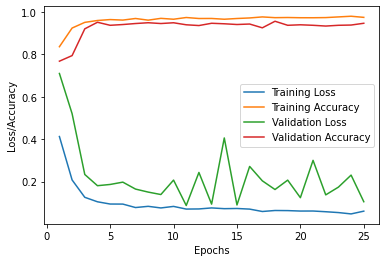

In [20]:
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [21]:
model.evaluate(x=test_generator)

7/7 [==============================] - 0s 7ms/step


[0.22317567467689514, 0.9269999861717224]